In this notebook respiratory health (lung function) ECRS are computed. Predictive performances are compared accross several models (XGBoost, Random Forest and LASSO) and finally Shapley values are extracted from the final ECRS to get local explanations.

# Data loading

In [51]:
# autoreload python file
%load_ext autoreload
%autoreload 2

# imports
import pandas as pd
import numpy as np
import sys
import json
import copy
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import optuna
import pickle
from scipy import stats
from datetime import date

# custom imports
import os
import sys
path = os.getcwd()
parent = os.path.dirname(path)
sys.path.append(parent)
from utils import fit_regr_skmodel, covariates_2steps_target_adjustement_cv, fit_2s, plot_dashboard, plot_shap_dashboard, get_lasso_feature_selection, compute_lasso_feature_selection, get_display_feature_mapping, fit_2step_regr_skmodel
from utils import extract_significant_interactions, plot_dependance_plots
from utils import delete_unwanted_covariates, extract_selected_features, adjust_sample_size_to_outcome, compute_covariates_variance_explained
from utils import covariates_2steps_target_adjustement_cohort_cv, cohorts_cv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# load codebook, one hot column list
codebook = pd.read_excel('../../../data/Helix data codebook.xlsx', na_values='NA')
selection = 'selection_respi'
with open('../../../data/imputed/mapping/one_hot_columns.json', 'r') as f:
    one_hot_columns = json.load(f)

In [53]:
# load health outcomes
health_outcomes = pd.read_csv("../../../data/outcomes/outcomes.csv").set_index("HelixID", drop=True, verify_integrity=True)
target_col = "FEV1_PP" # pfactor
print(health_outcomes.shape)

(1622, 3)


In [54]:
# Load imputed data
imputed_df = pd.read_csv("../../../data/imputed/mf_all_no_prs.csv").set_index('HelixID', drop=True, verify_integrity=True)
imputed_df.info()

# delete unwanted covariates
features = extract_selected_features(codebook, imputed_df, selection, one_hot_columns)

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, BIB10041 to SAB99
Columns: 478 entries, hs_zbmi_who to hs_nutr_supp_1.0
dtypes: float64(404), int64(74)
memory usage: 5.6+ MB
selected continuous covariates: ['h_mbmi', 'hs_child_age_days', 'h_age']
selected_categorical_covariates ['h_edumc', 'h_edufc', 'h_native', 'h_parity', 'seabir', 'cohort']
Dropped 2 covariates: ['e3_gac', 'hs_wgtgain']
Dropped 0 prs: []
Dropped 4 clinical factors: ['hs_asthma_1.0', 'hs_rhin_ly_1.0', 'hs_rhin_ly_2.0', 'hs_rhin_air_1.0']


In [56]:
# deletes rows with missing outcome
features, target = adjust_sample_size_to_outcome(features, health_outcomes[target_col])

Total number of missing values: 446
Using a feature dataframe of 1520 rows
Target column got 1176 non missing values
Adjusting sample size...
DF shape after merge: (1520, 473)
DF shape after droping NaNs (1176, 473)


<AxesSubplot:>

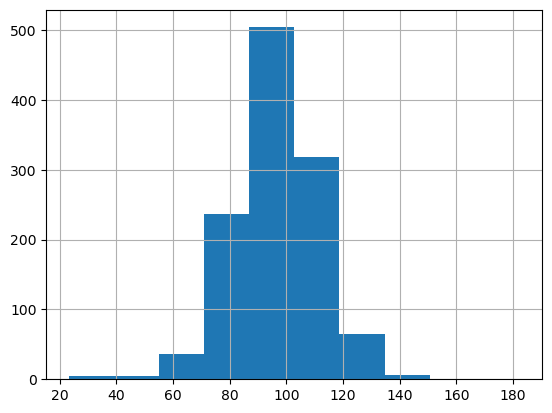

In [57]:
# standardize target
target.hist()

<AxesSubplot:>

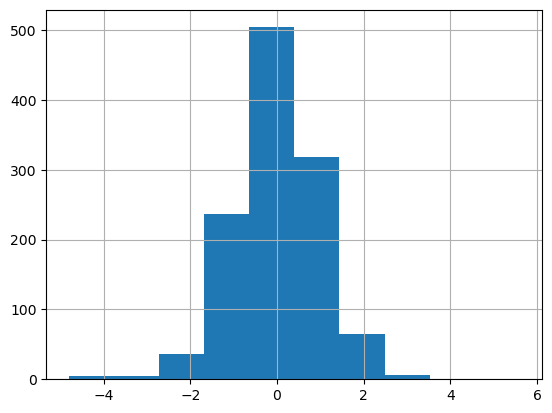

In [58]:
target = (target - target.mean())/target.std()
target.hist()

In [59]:
stats.kstest(target, 'norm')

KstestResult(statistic=0.02998335814995759, pvalue=0.23622508725924574)

In [60]:
# transformed_target = np.sqrt(target + np.abs(np.min(target)))
# transformed_target[(transformed_target < 1.5)] = 1.1 # erase outlier
# transformed_target.hist()

In [61]:
# transformed_target = (transformed_target - transformed_target.mean())/transformed_target.std()
# transformed_target.hist()

In [62]:
fs_covariates = ["cohort_1.0", "cohort_2.0", "cohort_3.0", 'cohort_4.0', 'cohort_5.0']

In [63]:
metabolites = []
proteins = []
covariates = []
clinical_markers = []
exposures = []

not_selected = []

skip_list = []
for col in features.columns:
    if col.endswith(".0"):
        col = col[:-4]
        if col in skip_list:
            continue
        skip_list.append(col)
    if codebook['selected'].loc[codebook['variable_name'] == col].iloc[0] != 1:
        not_selected.append(col)
    if codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Serum metabolome' or codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Urine metabolome':
        metabolites.append(col)
    elif codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Proteome':
        proteins.append(col)
    elif codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Covariates':
        covariates.append(col)
    elif codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors (cardio)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors (mental)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Parental clinical factors (mental)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors (respi)' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Lipids' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Clinical factors' or \
         codebook['family'].loc[codebook['variable_name'] == col].iloc[0] == 'Parental clinical factors':
            clinical_markers.append(col)
    else:
        exposures.append(col)

print("Number of metabolites:", len(metabolites))
print("Number of proteins:", len(proteins))
print("Number of covariates:", len(covariates))
print("Number of clinical markers:", len(clinical_markers))
print("Number of exposures:", len(exposures))

Number of metabolites: 78
Number of proteins: 34
Number of covariates: 10
Number of clinical markers: 17
Number of exposures: 303


# Hyperparameters tuning

In [64]:
# XGBoost tuning
def objective(trial, X, y):
    cohort_cols = ['cohort_1.0', 'cohort_2.0', 'cohort_3.0', 'cohort_4.0', 'cohort_5.0']
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.001),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.001),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0, step=0.001),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0, step=0.001),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0, step=0.1),
        'seed': 42,
        # 'tree_method': 'hist',  # for faster computation
    }
    
    # 10-fold CV
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Cohort adjustment on training split
        xgb_cov = XGBRegressor(learning_rate=0.1,
                               n_estimators=100,
                               max_depth=3,
                               gamma=0.1,
                               objective = "reg:squarederror", booster = "gbtree", use_label_encoder = False, seed = 42)
        xgb_cov.fit(X_train[cohort_cols], y_train)
        residuals_train = y_train - xgb_cov.predict(X_train[cohort_cols])
        
        # Train final model on residuals
        model = XGBRegressor(**params)
        model.fit(X_train.drop(columns=cohort_cols), residuals_train)
        
        # Cohort adjustment on validation split
        residuals_test = y_test - xgb_cov.predict(X_test[cohort_cols])
        
        # Predict on validation split
        preds = model.predict(X_test.drop(columns=cohort_cols))
        scores.append(r2_score(residuals_test, preds))

    # Return the average MSE
    return sum(scores) / len(scores)

In [65]:
# create new study
# name = f"xgb_2s_10f_cv {date.today()}"
# study_final = optuna.create_study(direction='maximize', study_name=name)

In [66]:
# load existing study
name = f"xgb_2s_10f_cv 2023-10-17"
with open(f"./optuna_trials/{name}.pkl", 'rb') as f:
    study_final = pickle.load(f)
print("study_final.study_name")

study_final.study_name


In [130]:
# optimize HP
try:
    study_final.optimize(lambda trial: objective(trial, features, target))
except KeyboardInterrupt:
    print("KeyboardInterrupt detected. Saving the study...")
    with open(f"./optuna_trials/{name}.pkl", 'wb') as f:
        pickle.dump(study_final, f)
    print("Study saved.")

[I 2023-10-21 22:49:11,018] Trial 8612 finished with value: 0.003985980307067471 and parameters: {'n_estimators': 296, 'min_samples_leaf': 93, 'max_leaf_nodes': 46, 'max_depth': 2, 'max_features': 0.26, 'min_samples_split': 2}. Best is trial 5995 with value: 0.039285382298298956.
[W 2023-10-21 22:51:24,345] Trial 8613 failed with parameters: {'n_estimators': 295, 'min_samples_leaf': 14, 'max_leaf_nodes': 8, 'max_depth': 12, 'max_features': 0.99, 'min_samples_split': 50} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jb/miniconda3/envs/exposome/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_23108/3894887333.py", line 3, in <lambda>
    study_final.optimize(lambda trial: objective(trial, features, target))
  File "/tmp/ipykernel_23108/4291488316.py", line 35, in objective
    model.fit(X_train.drop(columns=cohort_cols), residuals_train)
  File "

KeyboardInterrupt detected. Saving the study...
Study saved.


In [67]:
# Best hyperparameters
best_params = study_final.best_params
best_params['seed'] = 42
print("Best params are:", best_params , "with R2:", study_final.best_value)

Best params are: {'n_estimators': 318, 'max_depth': 1, 'min_child_weight': 6, 'learning_rate': 0.03952474311423335, 'subsample': 0.944, 'colsample_bytree': 0.915, 'reg_alpha': 0.20600000000000002, 'reg_lambda': 0.595, 'gamma': 2.2, 'seed': 42} with R2: 0.039285382298298956


In [68]:
assert(objective(study_final.best_trial, features, target) == study_final.best_value) # Sanity test

## Random forests

In [89]:
# XGBoost tuning
def objective_rf(trial, X, y):
    cohort_cols = ['cohort_1.0', 'cohort_2.0', 'cohort_3.0', 'cohort_4.0', 'cohort_5.0']
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 150),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 75),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0, step=0.01),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'random_state': 42,
        # 'tree_method': 'hist',  # for faster computation
    }
    
    # 10-fold CV
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Cohort adjustment on training split
        rf_cohort = RandomForestRegressor(n_estimators = 100,
                               # criterion="absolute_error",
                               min_samples_leaf = 90,
                               max_leaf_nodes = 8,
                               max_depth=5,
                               random_state = 42)
        rf_cohort.fit(X_train[cohort_cols], y_train)
        residuals_train = y_train - rf_cohort.predict(X_train[cohort_cols])
        
        # Train final model on residuals
        model = RandomForestRegressor(**params)
        model.fit(X_train.drop(columns=cohort_cols), residuals_train)
        
        # Cohort adjustment on validation split
        residuals_val = y_val - rf_cohort.predict(X_val[cohort_cols])
        
        # Predict on validation split
        preds = model.predict(X_val.drop(columns=cohort_cols))
        scores.append(r2_score(residuals_val, preds))

    # Return the average MSE
    return sum(scores) / len(scores)

In [90]:
# create new study
# name = f"RF_2s_10f_cv {date.today()}"
# study_rf = optuna.create_study(direction='maximize', study_name=name)

In [93]:
# load existing study
name = "RF_2s_10f_cv 2023-10-20"
with open(f"./optuna_trials/{name}.pkl", 'rb') as f:
    study_rf = pickle.load(f)

In [141]:
# optimize HP
try:
    study_rf.optimize(lambda trial: objective_rf(trial, features, target))
except KeyboardInterrupt:
    print("KeyboardInterrupt detected. Saving the study...")
    with open(f"./optuna_trials/{name}.pkl", 'wb') as f:
        pickle.dump(study_rf, f)
    print("Study saved.")

[I 2023-10-22 15:16:11,645] Trial 2118 finished with value: 0.020008623881333253 and parameters: {'n_estimators': 65, 'min_samples_leaf': 10, 'max_leaf_nodes': 16, 'max_depth': 7, 'max_features': 0.74, 'min_samples_split': 41}. Best is trial 1777 with value: 0.031297604438573046.
[I 2023-10-22 15:16:52,082] Trial 2119 finished with value: 0.02236174040717851 and parameters: {'n_estimators': 58, 'min_samples_leaf': 17, 'max_leaf_nodes': 18, 'max_depth': 9, 'max_features': 0.74, 'min_samples_split': 49}. Best is trial 1777 with value: 0.031297604438573046.
[I 2023-10-22 15:17:31,079] Trial 2120 finished with value: 0.021616169331861067 and parameters: {'n_estimators': 55, 'min_samples_leaf': 21, 'max_leaf_nodes': 17, 'max_depth': 12, 'max_features': 0.76, 'min_samples_split': 8}. Best is trial 1777 with value: 0.031297604438573046.
[I 2023-10-22 15:18:11,700] Trial 2121 finished with value: 0.01766359166360233 and parameters: {'n_estimators': 62, 'min_samples_leaf': 13, 'max_leaf_nodes':

KeyboardInterrupt detected. Saving the study...
Study saved.


In [94]:
# Best hyperparameters
rf_best_params = study_rf.best_params
rf_best_params['random_state'] = 42
print("Best params are:", rf_best_params , "with R2:", study_rf.best_value)

Best params are: {'n_estimators': 50, 'min_samples_leaf': 15, 'max_leaf_nodes': 17, 'max_depth': 8, 'max_features': 0.7000000000000001, 'min_samples_split': 48, 'random_state': 42} with R2: 0.031297604438573046


# Cross validation performances

In [69]:
print("mean:", target.mean(), "~ std:", target.std())

mean: 2.0835563055677896e-16 ~ std: 0.9999999999999982


1. linear regressions.

In [70]:
# lasso
lr_cov = LinearRegression()
lasso_risk = Lasso(selection='random', alpha=0.04, random_state=42)
lasso_test_scores = covariates_2steps_target_adjustement_cv(cov_model=lr_cov, res_model=lasso_risk,
                                        covariate_list=fs_covariates, features=features, target=target,
                                        standardize=True, verbose=False, save_results=True)

Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 5, means: -0.0013275009177288384
Results:
	step 1 mean train score: 0.154 std:0.01
	step 1 mean test score: 0.131 std:0.08
	step 2 mean train score: 0.121 std:0.01
	step 2 mean test score: 0.024 std:0.03
	final mean train score: 0.256 std:0.01
	final mean test score: 0.160 std:0.09


Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 5, means: -0.0013275009177288384


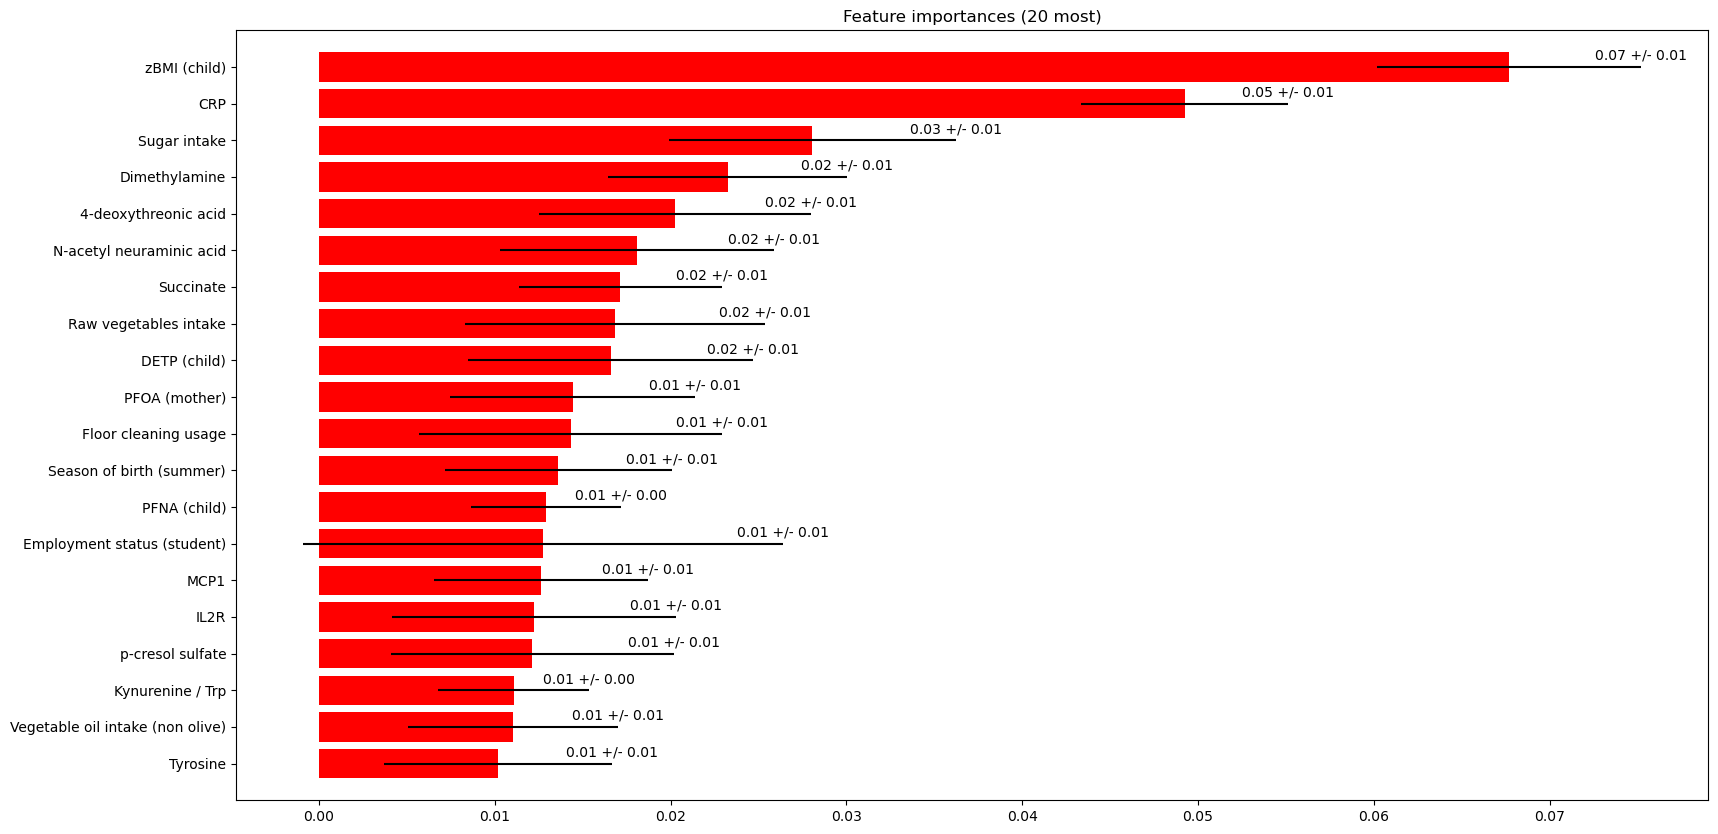

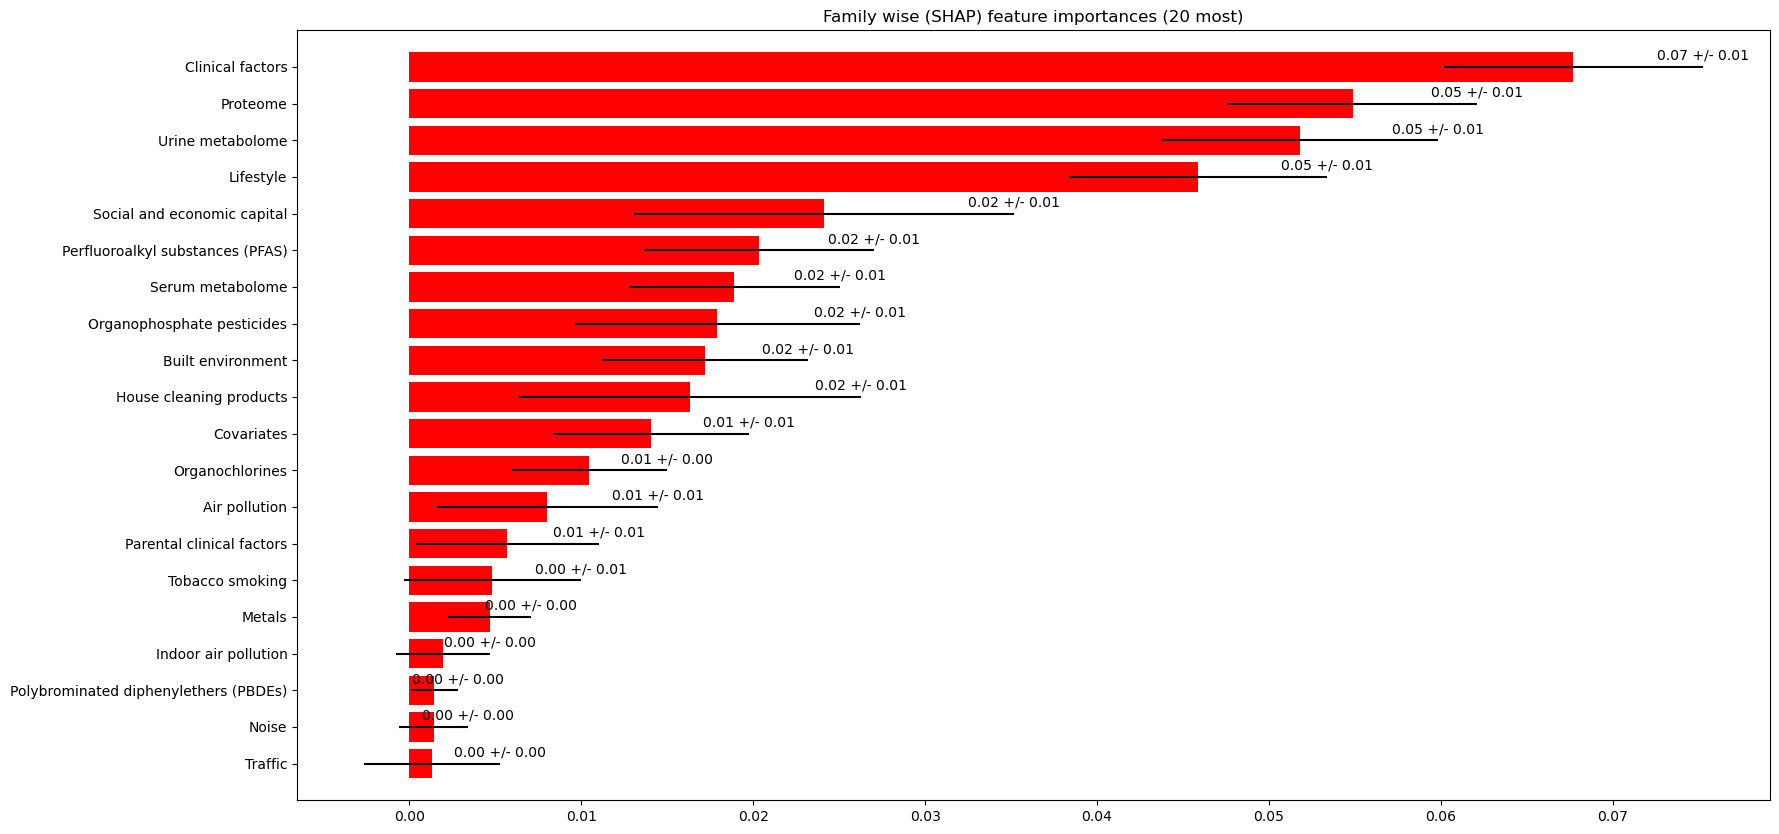

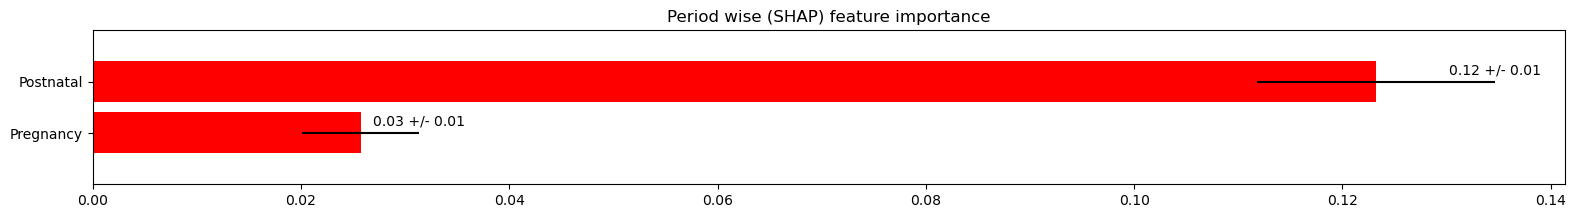

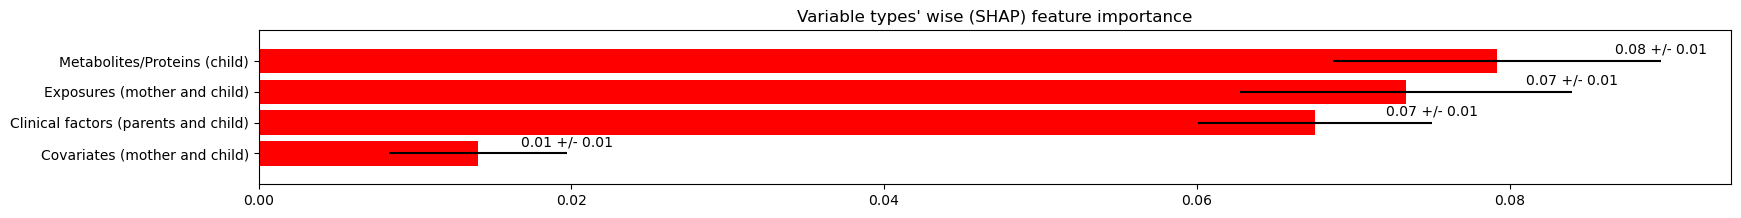

In [71]:
_ = covariates_2steps_target_adjustement_cv(cov_model=lr_cov,
                                            res_model=lasso_risk,
                                            covariate_list=fs_covariates,
                                            features=features,
                                            target=target,
                                            standardize=True,
                                            feature_selection_reg=None,
                                            verbose=False, save_results=False,
                                            feature_importance='shap')

2. random forests

In [95]:
rf_cov = RandomForestRegressor(n_estimators = 100,
                       # criterion="absolute_error",
                       min_samples_leaf = 90,
                       max_leaf_nodes = 8,
                       max_depth=5,
                       random_state = 454)
rf_risk = RandomForestRegressor(**rf_best_params)
_ = covariates_2steps_target_adjustement_cv(cov_model=rf_cov,
                                        res_model=rf_risk,
                                        covariate_list=fs_covariates,
                                        features=features,
                                        target=target,
                                        standardize=False,
                                        verbose=False, save_results=True)

Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 5, means: 0.0018835662932387726
Results:
	step 1 mean train score: 0.152 std:0.01
	step 1 mean test score: 0.128 std:0.07
	step 2 mean train score: 0.295 std:0.01
	step 2 mean test score: 0.031 std:0.03
	final mean train score: 0.403 std:0.01
	final mean test score: 0.164 std:0.08


3. xgboost

In [74]:
%%time
xgb_cov = XGBRegressor(learning_rate=0.1,
                       n_estimators=100,
                       max_depth=3,
                       gamma=0.1,
                       objective = "reg:squarederror", booster = "gbtree", use_label_encoder = False, seed = 42)

xgb_risk = XGBRegressor(**best_params)
xgb_test_scores = covariates_2steps_target_adjustement_cv(cov_model=xgb_cov,
                                        res_model=xgb_risk,
                                        covariate_list=fs_covariates,
                                        features=features,
                                        target=target,
                                        standardize=False,
                                        feature_selection_reg=None,
                                        verbose=False, save_results=True)

Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 5, means: 0.0017096031712679981
Results:
	step 1 mean train score: 0.153 std:0.01
	step 1 mean test score: 0.130 std:0.08
	step 2 mean train score: 0.221 std:0.00
	step 2 mean test score: 0.039 std:0.04
	final mean train score: 0.339 std:0.01
	final mean test score: 0.172 std:0.09
CPU times: user 58.8 s, sys: 2.33 s, total: 1min 1s
Wall time: 4.07 s


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Number of normaly distributed rediduals (Shapiro-Wild) on testing set: 5, means: 0.0017096031712679981


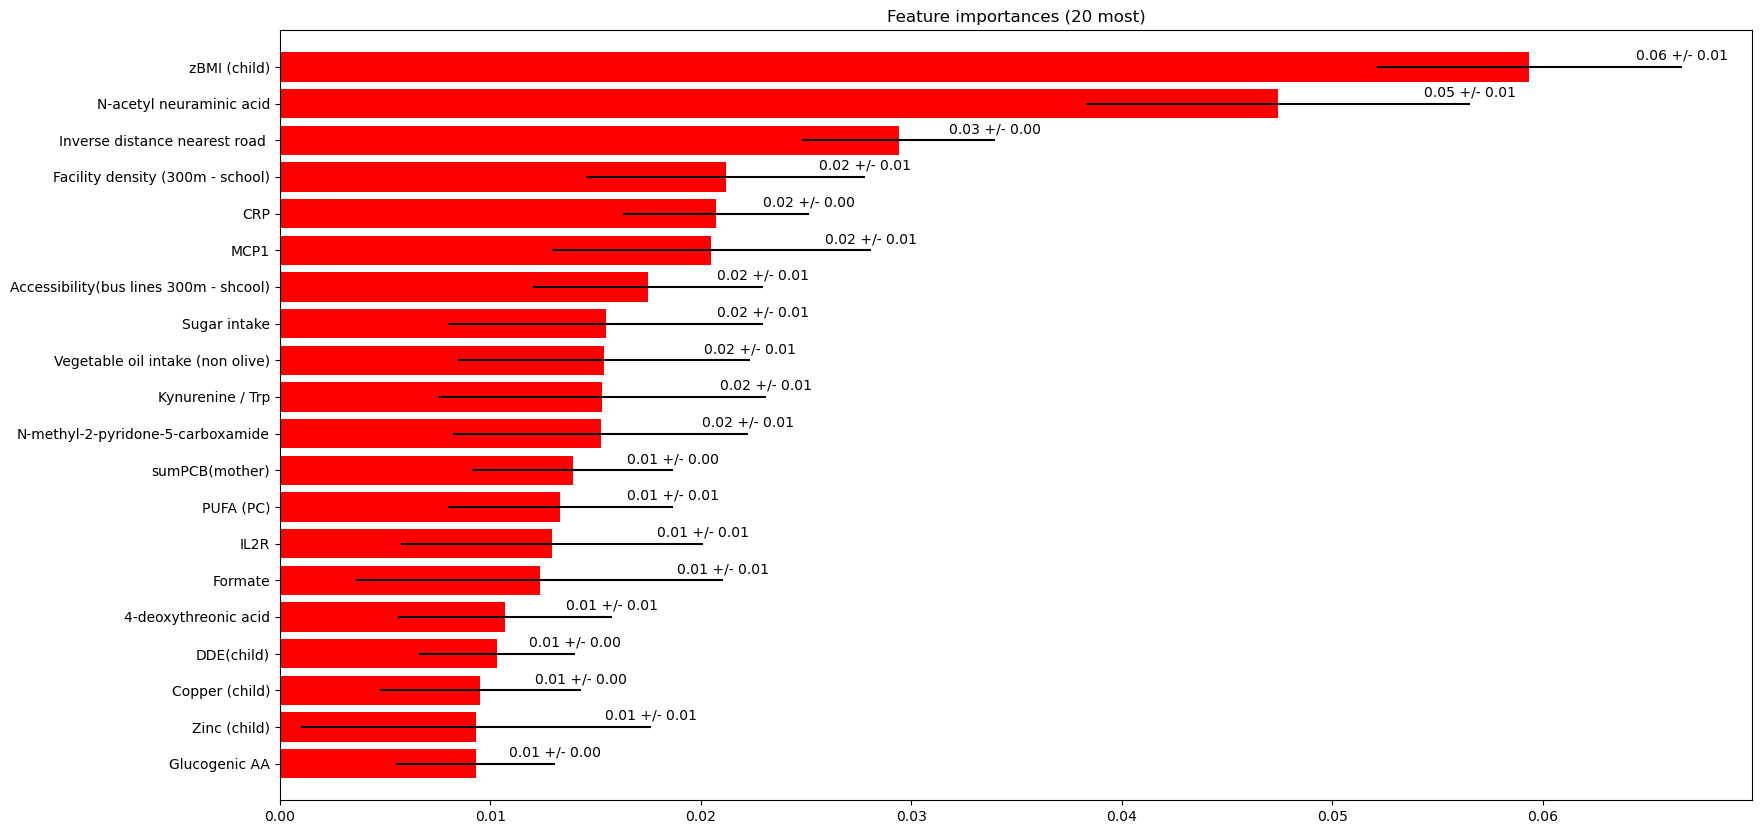

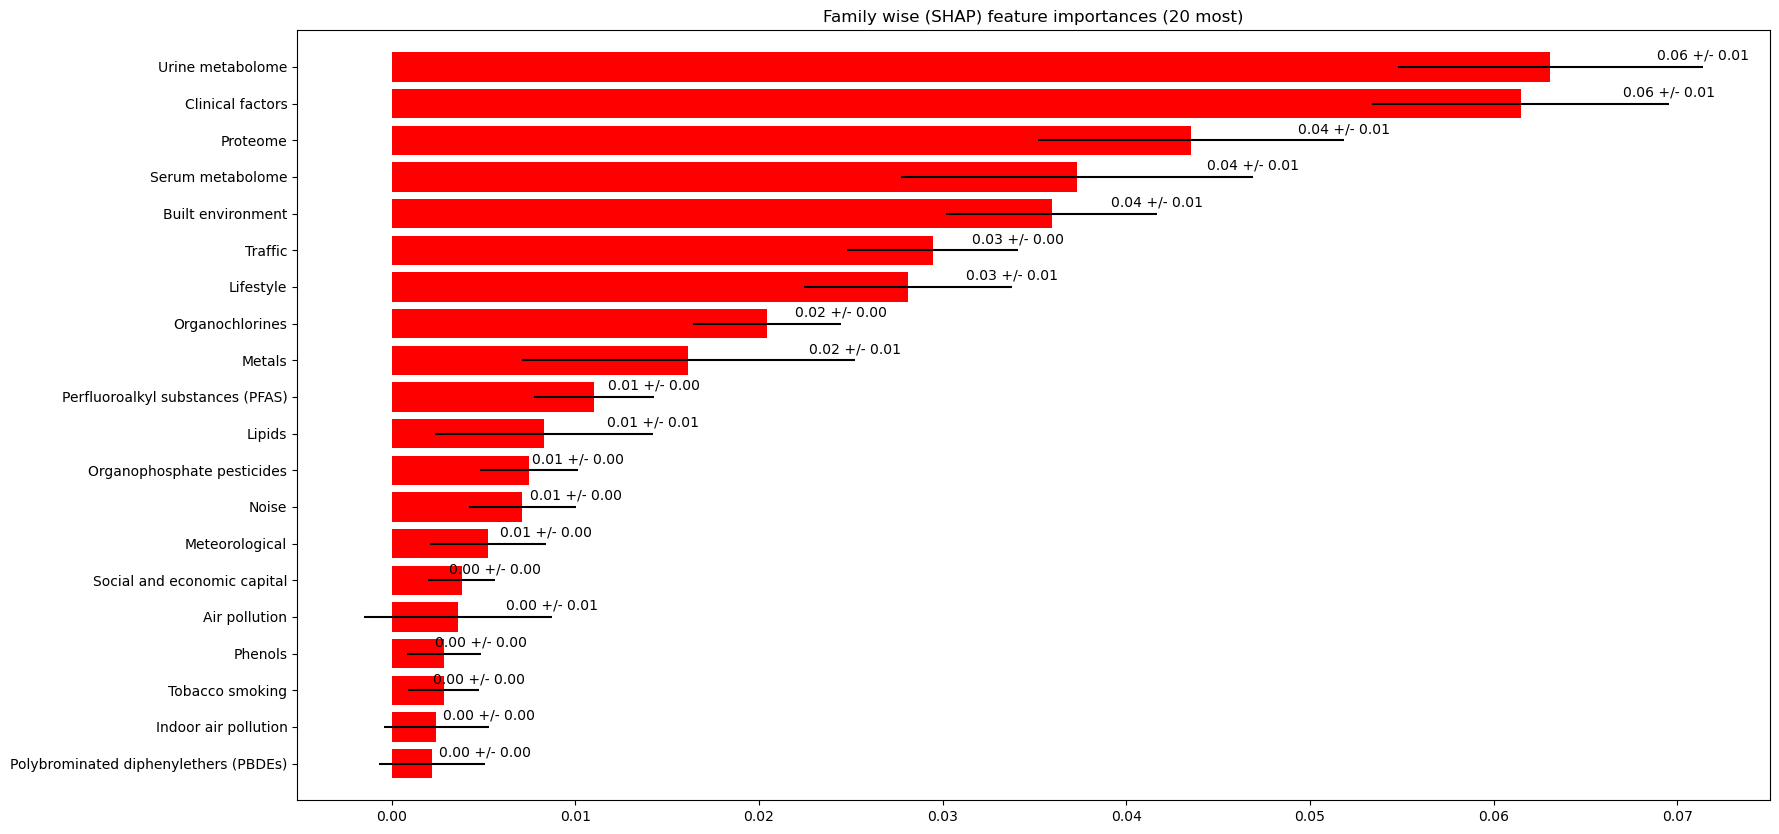

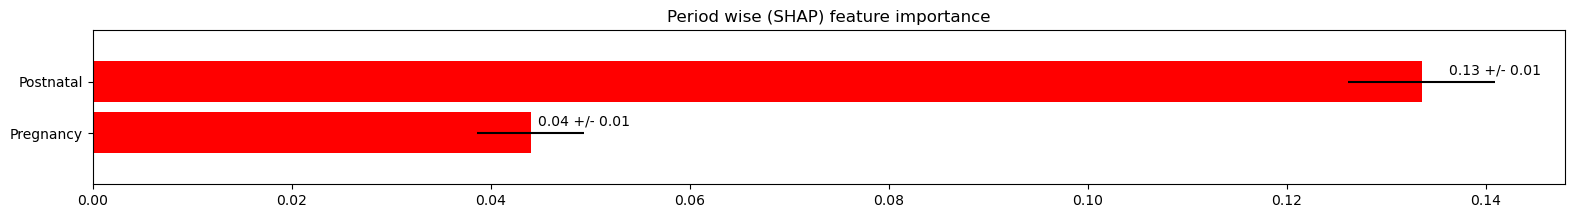

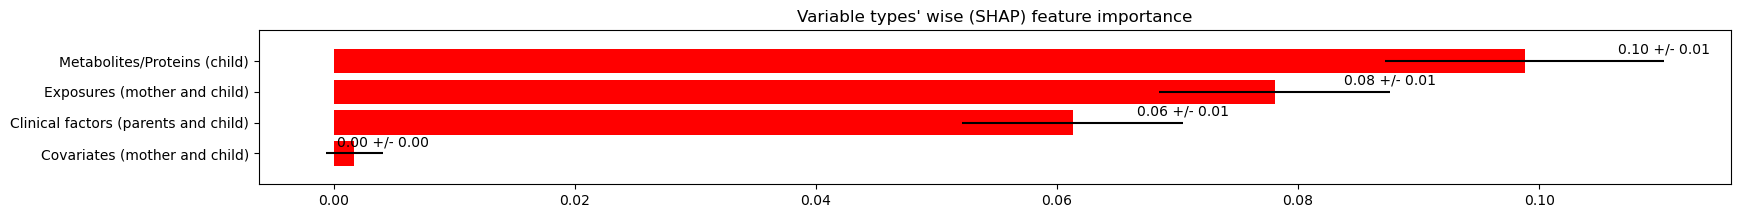

In [75]:
_ = covariates_2steps_target_adjustement_cv(cov_model=xgb_cov,
                                            res_model=xgb_risk,
                                            covariate_list=fs_covariates,
                                            features=features,
                                            target=target,
                                            standardize=False,
                                            feature_selection_reg=None,
                                            verbose=False, save_results=True,
                                            feature_importance='shap')

In [76]:
from scipy.stats import wilcoxon
from scipy import stats 
# print(lasso_test_scores, xgb_test_scores)
res = wilcoxon(lasso_test_scores, xgb_test_scores)
print(res.statistic, res.pvalue)

stats.ttest_rel(xgb_test_scores, lasso_test_scores)

15.0 0.232421875


Ttest_relResult(statistic=1.3294309742320034, pvalue=0.2164169174783471)

# Local explanations

step1 r2: 0.152 - step2 r2: 0.626 - final r2: 0.683


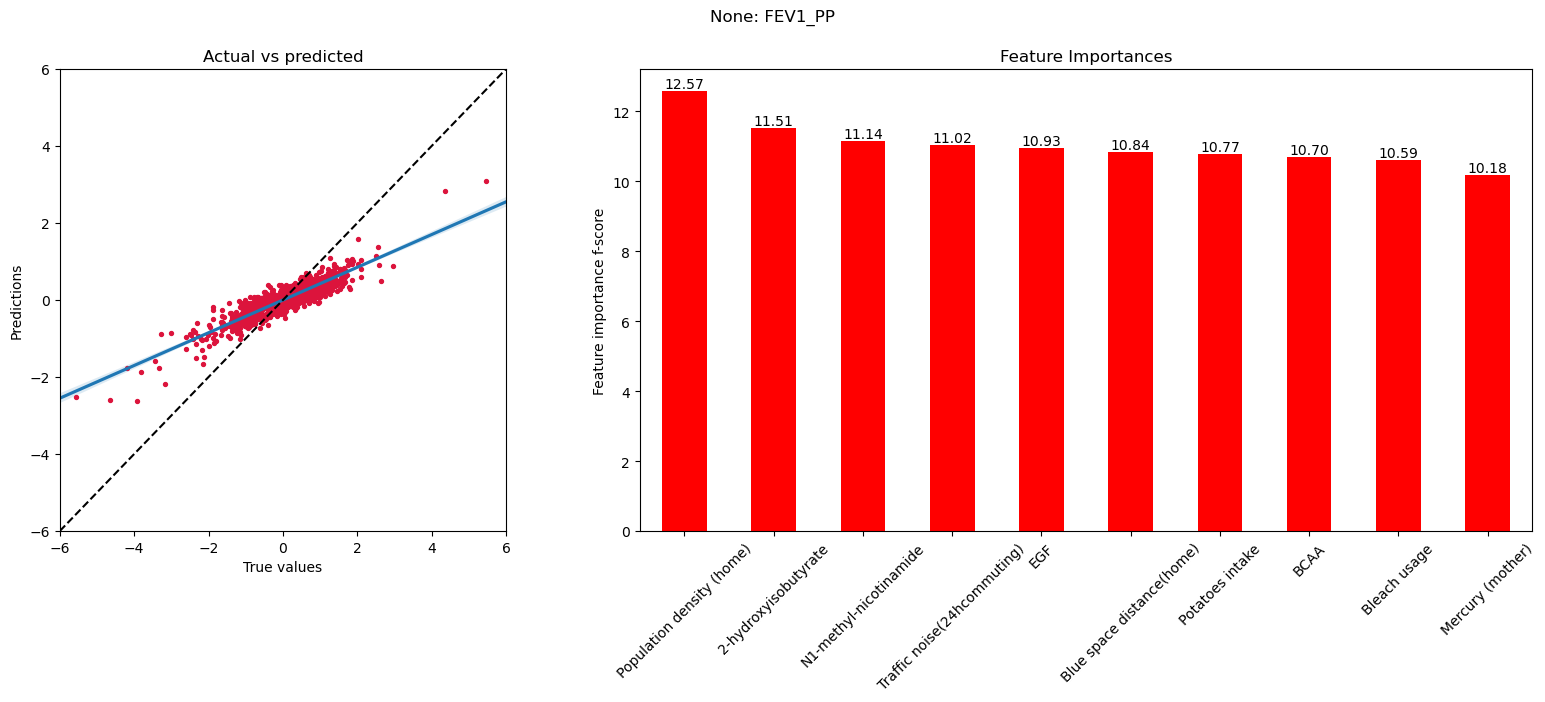

In [77]:
# Try without train/test split : model is trained on the entire dataset.
xgb_res = XGBRegressor(learning_rate=0.1,
                       n_estimators=100,
                       max_depth=3,
                       gamma=0.1,
                       objective = "reg:squarederror", booster = "gbtree", use_label_encoder = False, seed = 42)

xgb_risk = XGBRegressor(**best_params)
predicted_risk = fit_2s(xgb_cov, xgb_res, covariates=fs_covariates, features=features, target=target, selected_features=None, verbose=True)
predicted_risk = pd.DataFrame(predicted_risk, index=features.index, columns=['ERS_respi'])
predicted_risk.to_csv("./../../../results/ERS/respi.csv")

step1 r2: 0.153 - step2 r2: 0.284 - final r2: 0.394


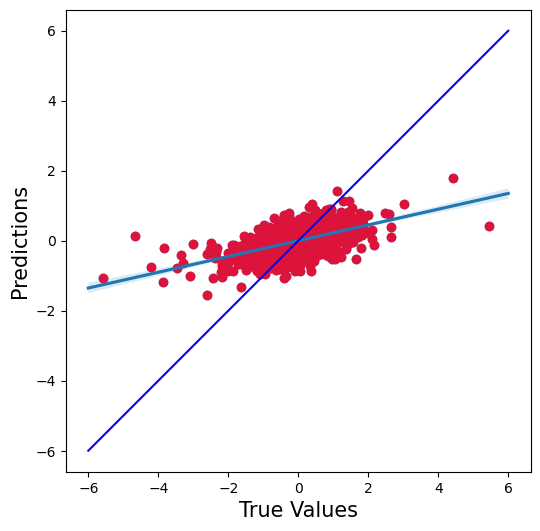

In [78]:
# Fit LASSO on the entire dataset.
# std features
cat_variables = []
for var in features.columns:
    if var.endswith(".0"):
        cat_variables.append(var)
scaler = StandardScaler()
std_X = scaler.fit_transform(features)
std_X = pd.DataFrame(data=std_X, columns=[ele for ele in features.columns], index=features.index)
std_X[cat_variables] = features[cat_variables]
std_features = std_X

std_features 
lr_cov = LinearRegression()
lasso_res = Lasso(selection='random', alpha=0.01, random_state=42)

predicted_risk = fit_2s(lr_cov, lasso_res, covariates=fs_covariates, features=std_features, target=target, selected_features=None, standardize=False, verbose=True)
predicted_risk = pd.DataFrame(predicted_risk, index=features.index, columns=['ERS_mental'])
predicted_risk.to_csv("./../../../results/ERS/respi_lasso.csv")

In [79]:
# compute Shapley values
import shap
explainer = shap.TreeExplainer(xgb_res,
                              feature_perturbation='tree_path_dependent') # 'interventional' requires to provides a background dataset.
updated_feature_selection = features.drop(["cohort_1.0", "cohort_2.0", "cohort_3.0", 'cohort_4.0', 'cohort_5.0'], axis=1, errors="ignore").columns
features_sample = features[updated_feature_selection].sample(frac=0.2, random_state=0)
shap_values = explainer(features_sample)

# get display_names
mapping_featurename_x_displayname = get_display_feature_mapping(shap_values.feature_names)
display_names = [mapping_featurename_x_displayname[key] for key in shap_values.feature_names]
display_shap = copy.deepcopy(shap_values)
display_shap.feature_names = display_names

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


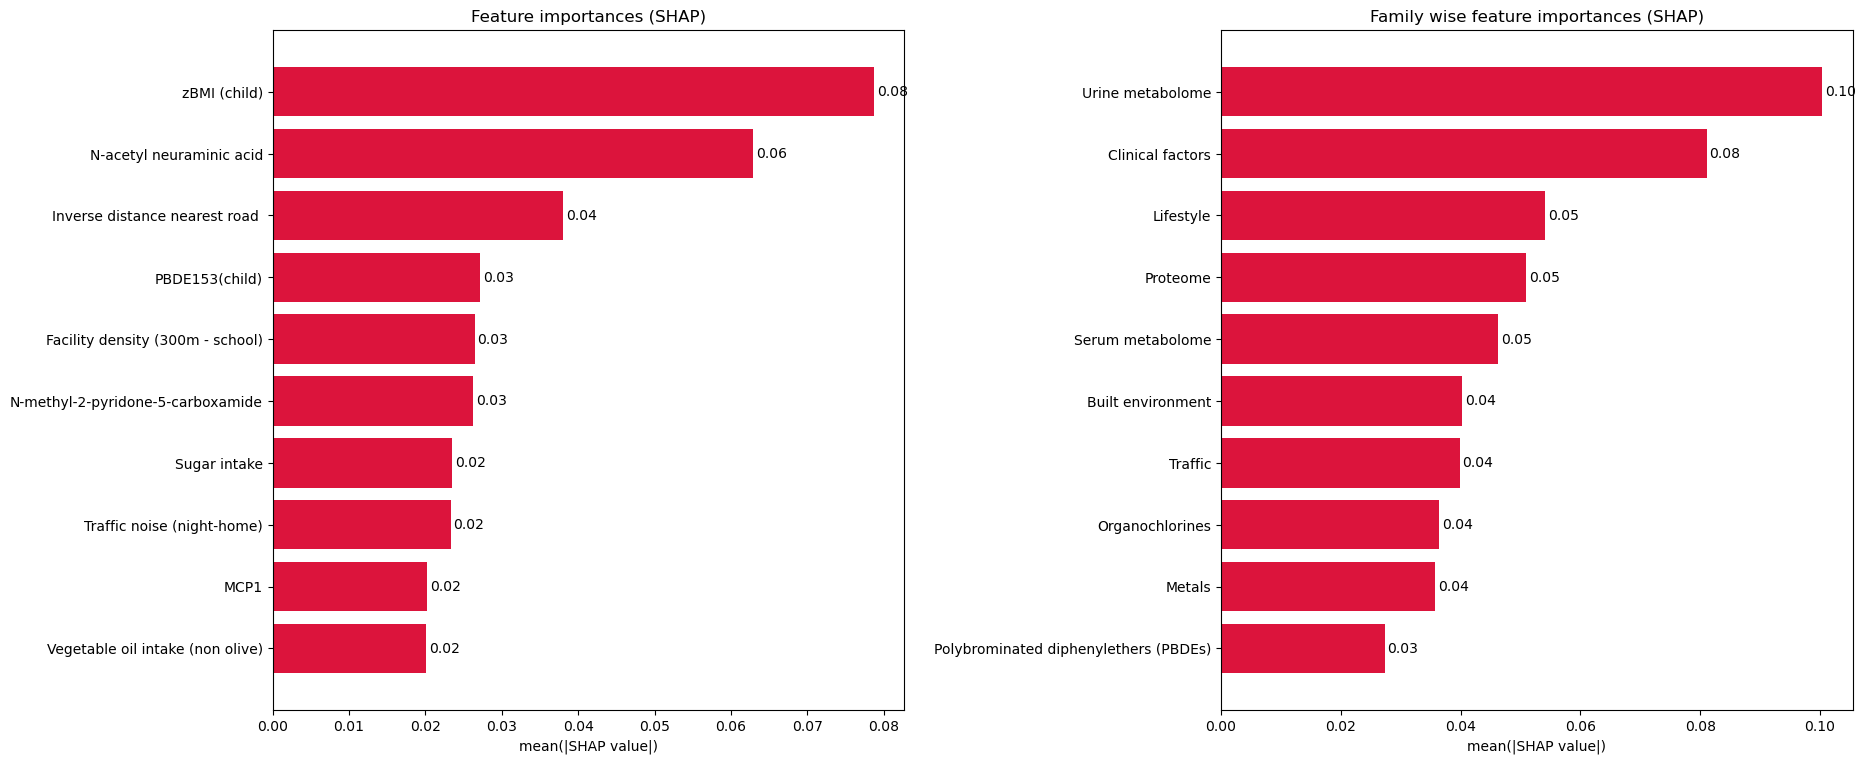

In [80]:
plot_shap_dashboard(shap_values, figsize=(19, 8))

In [81]:
# compute LASSO shapley values
import shap
updated_feature_selection = features.drop(["cohort_1.0", "cohort_2.0", "cohort_3.0", 'cohort_4.0', 'cohort_5.0'], axis=1, errors="ignore").columns
Lasso_explainer = shap.LinearExplainer(lasso_res, features[updated_feature_selection])
lasso_shap_values = Lasso_explainer(features[updated_feature_selection])

# get display_names
lasso_mapping_featurename_x_displayname = get_display_feature_mapping(lasso_shap_values.feature_names)
lasso_display_names = [lasso_mapping_featurename_x_displayname[key] for key in lasso_shap_values.feature_names]
lasso_display_shap = copy.deepcopy(lasso_shap_values)
lasso_display_shap.feature_names = lasso_display_names
lasso_display_shap.data = features.values # use original feature space

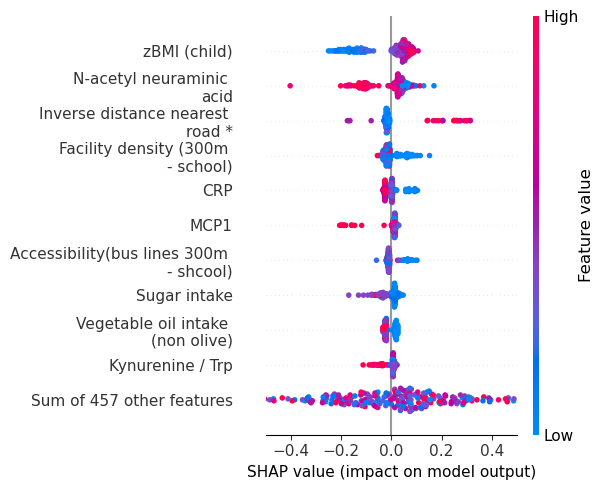

In [82]:
# Display beeswarm plot
import matplotlib.pyplot as plt
from utils import get_oh_x_orig_mapping

display_cpy = copy.deepcopy(display_shap) # ovoid weird bug with repetitive use of beeswarm method altering shapley values
number_of_features = 10

# use feature importance order obtained with cross validation.
fis = pd.read_excel('./../../../data/results/2steps_fi.xlsx').sort_values(['FEV1_PP mean feature importance'], ascending=False)
fis_order = list(fis['exposure'])[:number_of_features]
col2num = {col: i for i, col in enumerate(display_cpy.feature_names)}
order = list(map(col2num.get, fis_order))
padding = []
for i in range(len(display_cpy.feature_names)):
    if i not in order:
        padding.append(i)
order = order + padding

for i, feature in enumerate(display_cpy.feature_names):
    if len(feature) > 20:
        s = feature.split(" ")
        if len(s) > 1:
            ind = (len(s)+1)//2
            last = s[ind]
            s[ind] = '\n' + last
            # print(" ".join(s))
            display_cpy.feature_names[i] = " ".join(s)
        else:
            s = feature.split("-")
            ind = (len(s)+1)//2
            last = s[ind]
            s[ind] = '\n' + last
            display_cpy.feature_names[i] = "-".join(s)

# Add * after pregnancy variable names for display
codebook = pd.read_excel('./../../../data/Helix data codebook.xlsx', na_values='NA')[['variable_name', 'name_for_table', 'period']].set_index('variable_name')
mapping = get_oh_x_orig_mapping(list(shap_values.feature_names))
for i in range(0, len(list(shap_values.feature_names))):
    try:
        idx = codebook.loc[list(shap_values.feature_names)[i]]
    except KeyError:
        idx = codebook.loc[mapping[list(shap_values.feature_names)[i]]]
    if idx['period'] == 'Pregnancy':
        # print(list(display_cpy.feature_names)[i])
        display_cpy.feature_names[i] = list(display_cpy.feature_names)[i] + '*'
        # print("DEBUG: added * to:", labels[i])

shap.plots.beeswarm(display_cpy, max_display=number_of_features+1, order=order, show=False, color_bar=True)
# plt.title('Lung function', fontdict={'fontsize': 10, 'fontweight' : 'bold'})
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(6, 5)
# ax.yaxis.label.set_size(40) # no effect
ax.xaxis.label.set_size(11)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
plt.xlim([-0.5, 0.5])
fig.tight_layout()

plt.savefig('./../../../data/results/images/lf_local_exp.png')
plt.show()

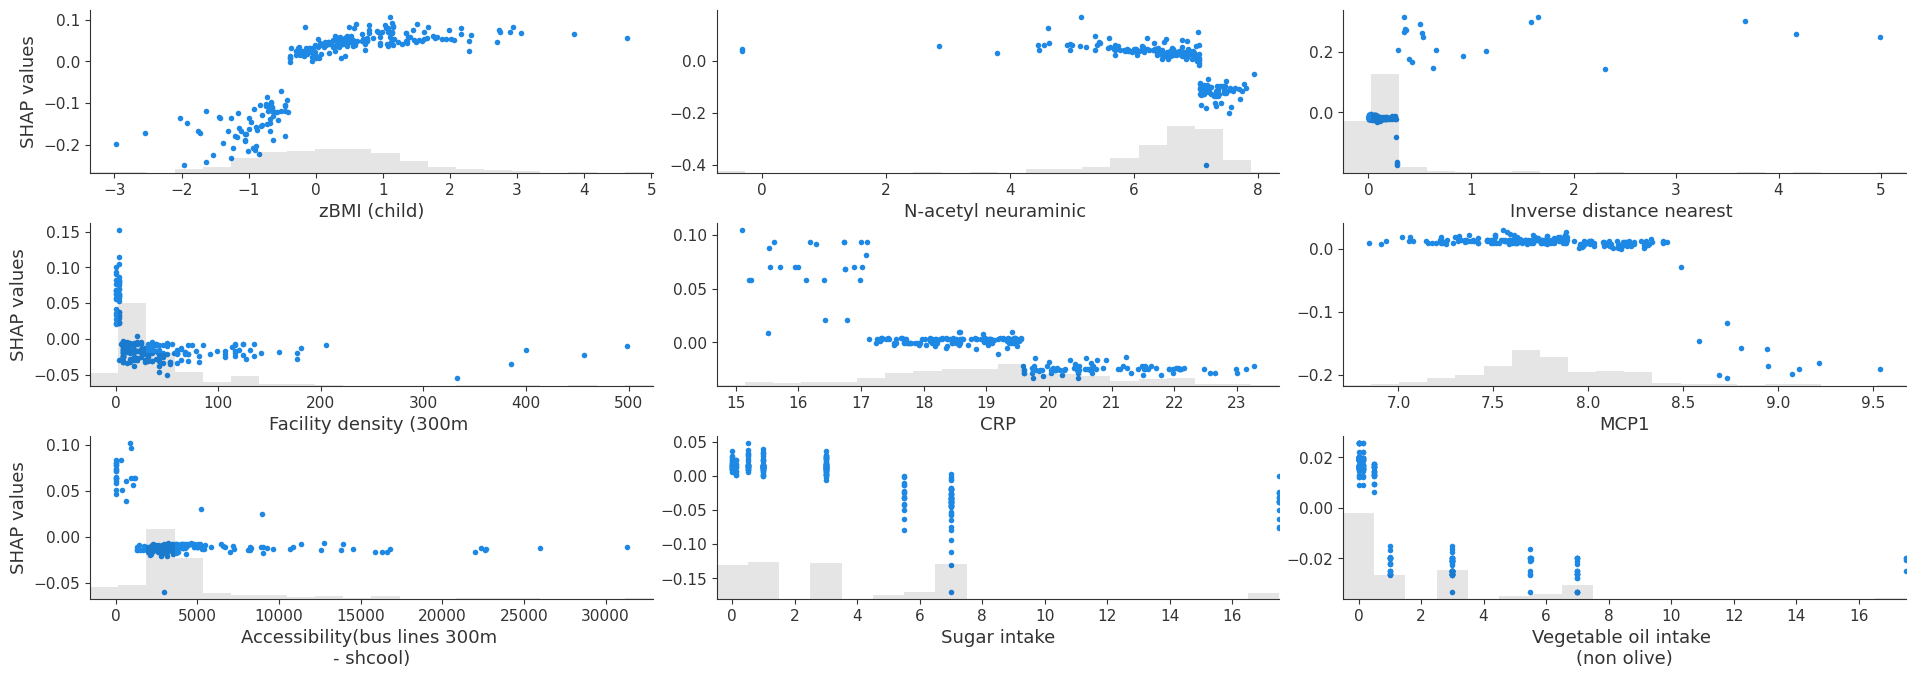

In [83]:
# diplays dependance plots
n_col, n_lin = 3, 3
fig, axes = plt.subplots(n_lin, n_col, figsize=(19, n_lin * 2.2), gridspec_kw={"width_ratios" : [1, 1, 1]}, sharey=False)
# fig.suptitle("Lung function", fontsize=14, fontweight='bold')
fig.tight_layout(pad=1.5)
for l in range(0,n_lin):
    for c in range(0, n_col):
        shap.plots.scatter(display_cpy[:, order[l * n_col + c]], ax=axes[l, c], show=False)
        if c == 0:
            axes[l, c].set_ylabel("SHAP values")
        else:
            axes[l, c].set_ylabel("")
plt.savefig('./../../../data/results/lf_dependance_plots.png', bbox_inches="tight")
plt.show()

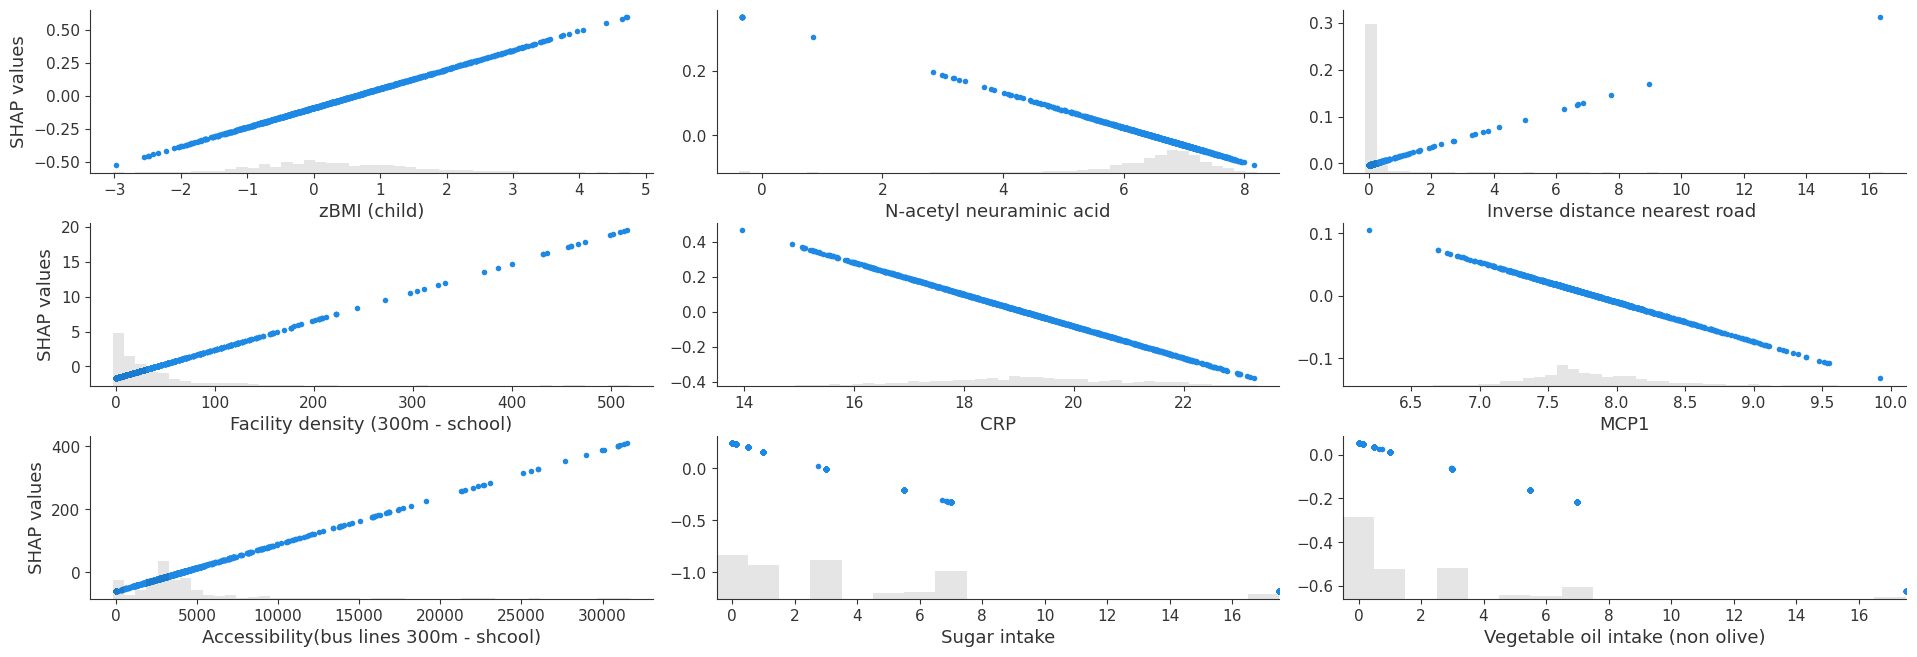

In [84]:
# diplays dependance plots
n_col, n_lin = 3, 3
fig, axes = plt.subplots(n_lin, n_col, figsize=(19, n_lin * 2.2), gridspec_kw={"width_ratios" : [1, 1, 1]}, sharey=False)
# fig.suptitle("P-factor", fontsize=14, fontweight='bold')
fig.tight_layout(pad=1.5)
for l in range(0,n_lin):
    for c in range(0, n_col):
        shap.plots.scatter(lasso_display_shap[:, order[l * n_col + c]], ax=axes[l, c], show=False)
        if c == 0:
            axes[l, c].set_ylabel("SHAP values")
        else:
            axes[l, c].set_ylabel("")
plt.savefig('./../../../data/results/lf_dependance_plots_lasso.png', bbox_inches="tight")
plt.show()

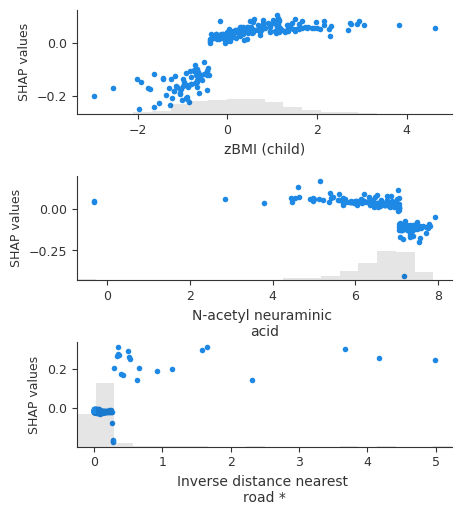

In [85]:
# Column wise dependance plots for figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 5), gridspec_kw={"width_ratios" : [1]}, sharey=False)
# fig.suptitle("Lung function", fontsize=14, fontweight='bold')
shap.plots.scatter(display_cpy[:, order[0]], ax=ax1, show=False)
shap.plots.scatter(display_cpy[:, order[1]], ax=ax2, show=False)
shap.plots.scatter(display_cpy[:, order[2]], ax=ax3, show=False)
fontsize=10
ax1.xaxis.get_label().set_fontsize(fontsize)
ax2.xaxis.get_label().set_fontsize(fontsize)
ax3.xaxis.get_label().set_fontsize(fontsize)
fig.tight_layout(pad=0.1)
# ax2.xticks(fontsize=14, rotation=90)
for tick in ax1.xaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax1.yaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax2.xaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax2.yaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax3.xaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
for tick in ax3.yaxis.get_major_ticks():
                tick.label.set_fontsize(fontsize-1)
ax1.set_ylabel("SHAP values", fontsize=9)
ax2.set_ylabel("SHAP values", fontsize=9)
ax3.set_ylabel("SHAP values", fontsize=9)
plt.savefig('./../../../data/results/lf_col_dependance_plots.png', bbox_inches="tight")
plt.show()

In [86]:
# compute SHAP interactions
shap_interaction = explainer.shap_interaction_values(features[updated_feature_selection])
print(shap_interaction.shape)

(1176, 467, 467)


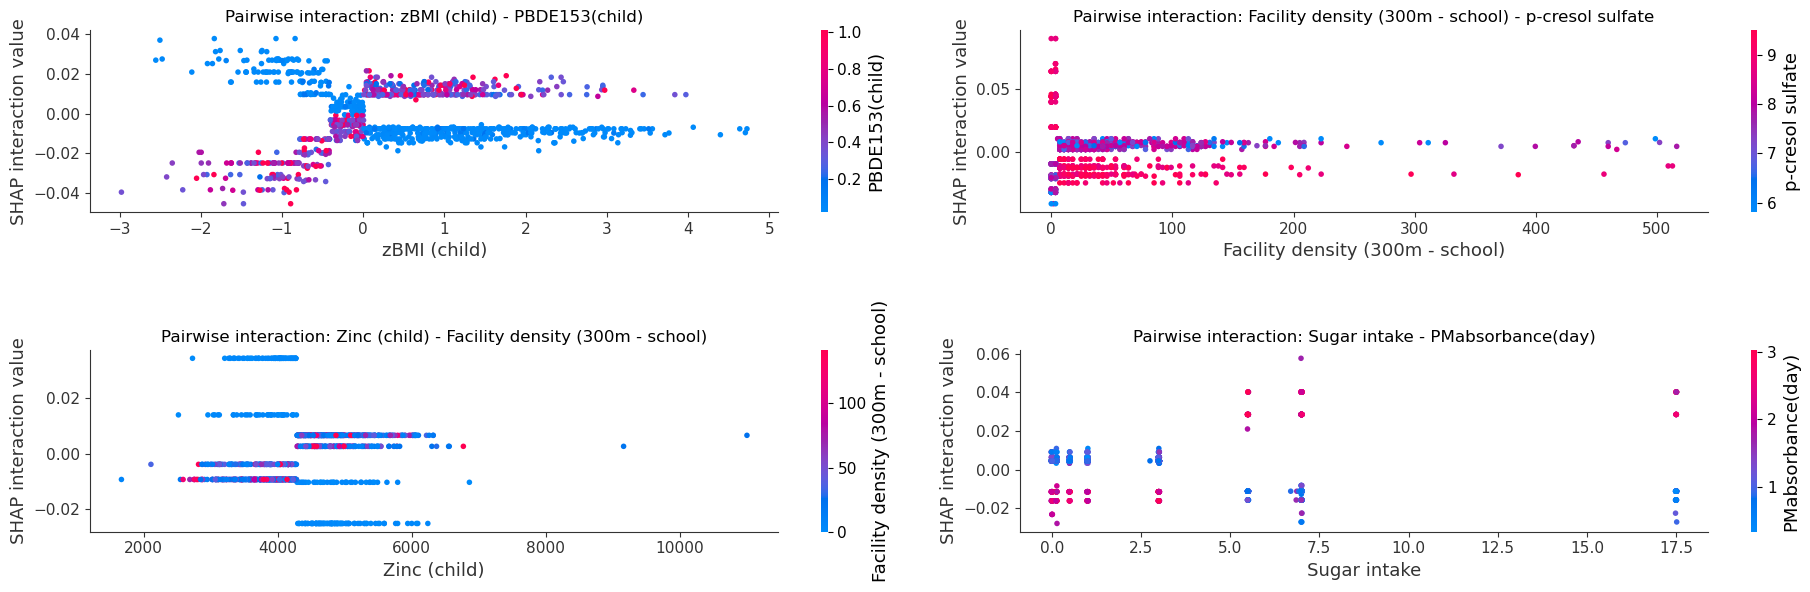

In [87]:
# compute pairwise interactions
significant_interactions = extract_significant_interactions(shap_interactions=shap_interaction, feature_names=updated_feature_selection, percent=10, threshold=0.006, mode='mean')
plot_dependance_plots(shap_interactions=shap_interaction, features=features, feature_names=updated_feature_selection, significant_interactions=significant_interactions[0:4], title="Lung function pairwise interactions")

In [88]:
# Compute marginal and interaction effects size
tmp = np.abs(shap_interaction).mean(0)
interaction_strengths_dict = {}
marginal_effect_dict = {}
for i in range(tmp.shape[0]):
    for j in range(i, tmp.shape[1]):
        if tmp[i, j] > 0:
            f1 = updated_feature_selection[i]
            f2 = updated_feature_selection[j]
            key = f1 + '_XXX_' + f2
            if f1==f2:
                marginal_effect_dict[f1] = tmp[i, j]
            else:
                interaction_strengths_dict[key] = 2 * tmp[i, j] # interaction(x1<=>x2) = interaction(x1.x2) + interaction(x2.x1)

marginal_effect_dict = {k: v for k, v in sorted(marginal_effect_dict.items(), key=lambda item: item[1], reverse=True)} # sort by value    
interaction_strengths_dict = {k: v for k, v in sorted(interaction_strengths_dict.items(), key=lambda item: item[1], reverse=True)} # sort by value                
          
print("marginal effets: mean shapley values:", np.mean(list(marginal_effect_dict.values())[0:10]))
print("interaction effects: mean shapley values:", np.mean(list(interaction_strengths_dict.values())[0:10]))
print("ratio:", np.mean(list(marginal_effect_dict.values())[0:10]) / np.mean(list(interaction_strengths_dict.values())[0:10]))

marginal effets: mean shapley values: 0.032510307
interaction effects: mean shapley values: 0.009396222187206149
ratio: 3.4599337945018824


# Cohort CV 

In [34]:
transformed_features = features.copy(deep=True)
transformed_features['cohort_6.0'] = (transformed_features[fs_covariates].sum(axis=1) == 0).astype(int)

**Standardize per cohorts**

In [ ]:
# Get the original cohort values from the one-hot encoded columns
cohorts = transformed_features.filter(like="cohort_").idxmax(axis=1).str.replace("cohort_", "").astype(float).astype(int)

# Function to standardize a series
def standardize(series):
    return (series - series.mean()) / series.std()

# Create copies to store standardized values
standardized_features = transformed_features.copy()
standardized_target = target.copy()

# Standardize features and target per cohort
for cohort, indices in cohorts.groupby(cohorts).groups.items():
    features_subset = standardized_features.loc[indices]
    for feature_col in features_subset.columns.difference(cohorts.index):  # Only non-cohort columns
        standardized_features.loc[indices, feature_col] = standardize(features_subset[feature_col])
    standardized_target.loc[indices] = standardize(target[indices])

# standardized_features = standardized_features.dropna(axis=1, how='all')
cohorts = [f"cohort_{i}.0" for i in range(1, 7)]
standardized_features[cohorts] = transformed_features[cohorts]

In [72]:
xgb_risk = XGBRegressor(**best_params)
xgb_test_scores = covariates_2steps_target_adjustement_cohort_cv(cov_model=xgb_cov, 
                                                                 res_model=xgb_risk,
                                                                 features=standardized_features,
                                                                 target=standardized_target,
                                                                 standardize=False)

Results:
	step 1 mean train score: -0.000 std:0.00
	step 1 mean test score: -0.000 std:0.00
	step 2 mean train score: 0.159 std:0.01
	step 2 mean test score: 0.024 std:0.02
	final mean train score: 0.159 std:0.01
	final mean test score: 0.024 std:0.02
Complete results
	step 1 mean train scores: [-1.8131007806232446e-10, -1.8122725542468743e-10, -1.8164247883589724e-10, -1.8129653334142404e-10, -1.8134027612859427e-10, -1.812163752390461e-10]
	step 1 mean test score: [-1.8140111635034373e-10, -1.8137935597906107e-10, -1.813369454595204e-10, -1.8138113233590047e-10, -1.8128010204065959e-10, -1.8137580326538227e-10]
	step 2 mean train score: [0.14997503949631796, 0.1556622653113109, 0.1596937431363975, 0.16283972251026502, 0.1730836388111967, 0.14986630561980496]
	step 2 mean test score: [0.03421977885892069, 0.03604672155858302, 0.02810532118493081, 0.010042490631870904, -0.008797943452235168, 0.0456876452668854]
	final mean train score: [0.14997503935645795, 0.1556622648854128, 0.159693